# Theme 4: Convolutional Neural Networks (CNN)

In this exercise set we use as a basis the same dataset and code as in Theme 3, but this time we extend it to a Convolutional Neural Network (CNN) for classification.

## Goals
1.  **CNN Basics**: Build a simple CNN with Strided Convolutions.
2.  **Pooling**: Understand the effect of MaxPooling.
3.  **Visualization**: Visualize learned kernels.
4.  **Batch Normalization**: Improve training stability.
5.  **Regularization**: Apply L2 regularization to CNNs.


## 1. Imports

We add `Conv2D`, `MaxPooling2D`, and `BatchNormalization` to our toolkit.


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras import regularizers
from PIL import Image
import matplotlib.pyplot as plt
import os

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 2. Helper Functions

In Deep Learning, data plumbing is often 80% of the work. We need robust functions to:
- **Load Labels**: Read class IDs from text files.
- **Load Images**: Read image files into NumPy arrays.
- **Normalize**: Scale pixel values to a small range (e.g., -1 to 1 or 0 to 1) to help the optimizer converge.
- **Split**: Separate data into Testing and Validation sets to ensure we don't cheat by optimizing on our test data.

*Self-Learning Note*: Notice `normalize_dataset`. It shifts data to be 0-centered (approx) by subtracting 128 and dividing by 128. This helps gradient descent steps be more uniform.


In [8]:
# --- Helper Functions ---
def load_labels(filename):
    with open(filename,'r') as file:
       li = file.readlines()
    label_count = len(li)
    labels = np.empty((label_count,1), dtype='int')
    i = 0
    with open(filename) as f:
        for line in f:
            labels[i] = int(line.replace("\n", ""))
            i = i + 1
    return labels

def load_images(folder, image_count, image_size):
    array_shape = (image_count, image_size[0], image_size[1], image_size[2])
    imageset = np.empty(array_shape, dtype='float')
    for i in range(0,image_count):
        fname = os.path.join(folder, 'image_' + "{:04d}".format(i) + '.png')
        if not os.path.exists(fname):
             print(f"Warning: File {fname} not found.")
             continue
        image = Image.open(fname)
        imageset[i] = np.asarray(image)
    return imageset

def normalize_dataset(sampled_images):
    # Scale to range [-1, 1] approx
    sampled_images = (sampled_images.astype('float32')-128) / 128
    return sampled_images

def split_test_val(data, splitpoint):
    # Returns (Tail, Head) - careful with indices!
    return data[splitpoint:], data[:splitpoint]

def create_model(input_shape, dense_size, classes, l2_reg=None):
    x = Input(shape=(input_shape))
    y = Flatten()(x)
    
    if l2_reg:
        y = Dense(classes, activation='softmax', name='dense_layer', kernel_regularizer=l2_reg)(y)
    else:
        y = Dense(classes, activation='softmax', name='dense_layer')(y)
        
    model = Model(inputs=x, outputs=y)
    return model

def create_model_2_layers(input_shape, dense_size, classes):
    x = Input(shape=(input_shape))
    y = Flatten()(x)
    # Task 7: 2nd dense layer usually adds 'depth' allowing complex features
    y = Dense(dense_size, activation='relu', name='dense_layer_1')(y)
    y = Dense(classes, activation='softmax', name='dense_layer_out')(y)
    model = Model(inputs=x, outputs=y)
    return model

def visualize_weights(model, layer_name, title, filename):
    try:
        weights, biases = model.get_layer(layer_name).get_weights()
    except ValueError:
        print(f"Layer {layer_name} not found or has no weights")
        return

    # Weights shape: (InputDim, Units) -> (3072, 10)
    input_shape = (32, 32, 3)
    n_units = weights.shape[1]
    
    # We want to show the weights for each class (unit)
    rows = 2
    cols = 5 
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    
    for i, ax in enumerate(axes.flat):
        if i >= n_units:
            break

        weight_vector = weights[:, i]
        # Reshape: (3072,) -> (32, 32, 3)
        weight_image = weight_vector.reshape(input_shape)

        # Normalize to 0-1 for display
        min_val = weight_image.min()
        max_val = weight_image.max()
        weight_image = (weight_image - min_val) / (max_val - min_val + 1e-5)

        ax.imshow(weight_image)
        ax.set_title(f'Class {i}')
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show() # Changed from savefig to show for notebook
    print(f"Visualization generated.")


## 3. Loading Data

We load the CIFAR-10 subset.
We assume the `resources` folder is in the current working directory.


In [9]:
print("--- Loading Data ---")
base_res = 'resources' # Assumed relative to CWD
if not os.path.exists(base_res):
    print(f"ERROR: '{base_res}' directory not found. Please ensure you are in the correct directory.")
else:
    # 1. Load Labels
    y_train = load_labels(os.path.join(base_res, 'training/labels.csv'))
    
    # 2. Load Images (based on how many labels we have)
    x_train_raw = load_images(os.path.join(base_res, 'training'), len(y_train), (32,32,3))
    
    Y_test = load_labels(os.path.join(base_res, 'testing/labels.csv'))
    X_test_raw = load_images(os.path.join(base_res, 'testing'), len(Y_test), (32,32,3))

    print("Data Loaded.")

--- Loading Data ---
Data Loaded.


## 4. Normalization & Splitting

**Normalization**: Raw pixel values are 0-255. Neural networks prefer inputs near 0 with unit variance. We subtract 128 and divide by 128.

**Splitting**: We split the 'Test' set folder into a true 'Test' set and a 'Validation' set.
- **Validation**: Used during training to check progress.
- **Test**: Used ONLY at the very end to report final performance.


In [10]:
x_train = normalize_dataset(x_train_raw)
X_test = normalize_dataset(X_test_raw)

# Splitting logic from original script
# index 0 to 2000 -> Validation
# index 2000 to End -> Test
splitpoint = 2000
x_test, x_val = split_test_val(X_test, splitpoint)
y_test, y_val = split_test_val(Y_test, splitpoint)

class_count = len(np.unique(y_train))
dims = (32, 32, 3)
dense_sz = 100

print(f"Training set: {x_train.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set: {x_test.shape}")
print(f"Classes: {class_count}")

Training set: (10000, 32, 32, 3)
Validation set: (2000, 32, 32, 3)
Test set: (3000, 32, 32, 3)
Classes: 10


## 2. First CNN: Strided Convolutions



Instead of flattening the image immediately, we use `Conv2D` layers to extract spatial features.

We use `strides=2` to downsample the efficient spatial dimensions instead of pooling.



**Architecture**:

1.  Input (32, 32, 3)

2.  Conv2D (32 filters, 3x3, stride=2, padding='same')

3.  Conv2D (64 filters, 3x3, stride=2, padding='same')

4.  Flatten

5.  Dense (100)

6.  Dense (10 classses)



**Hyperparameters**:

-   Epochs: 12

-   Learning Rate: 3e-4



In [11]:
def create_cnn_strided(input_shape, dense_size, classes):

    kernel_sz = (3, 3)

    x = Input(shape=input_shape)

    # 1st Conv Block

    y = Conv2D(filters=32, kernel_size=kernel_sz, strides=2, activation='relu', 

               padding='same', kernel_initializer='he_normal')(x)

    # 2nd Conv Block

    y = Conv2D(filters=64, kernel_size=kernel_sz, strides=2, activation='relu', 

               padding='same', kernel_initializer='he_normal')(y)

    

    y = Flatten()(y)

    y = Dense(dense_size, activation='relu')(y)

    y = Dense(classes, activation='softmax')(y)

    

    model = Model(inputs=x, outputs=y)

    return model



print("--- Training Strided CNN ---")

model_stride = create_cnn_strided(dims, dense_sz, class_count)

model_stride.compile(loss='sparse_categorical_crossentropy', 

                     optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), 

                     metrics=['accuracy'])

model_stride.summary()



history_stride = model_stride.fit(x_train, y_train, epochs=12, validation_data=(x_val, y_val), verbose=2)


--- Training Strided CNN ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,102 (1.64 MB)

 Trainable params: 430,102 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
313/313 - 3s - 10ms/step - accuracy: 0.3693 - loss: 1.7940 - val_accuracy: 0.4385 - val_loss: 1.5682
Epoch 2/12
313/313 - 2s - 5ms/step - accuracy: 0.5086 - loss: 1.4080 - val_accuracy: 0.5055 - val_loss: 1.4187
Epoch 3/12
313/313 - 2s - 5ms/step - accuracy: 0.5736 - loss: 1.2218 - val_accuracy: 0.5065 - val_loss: 1.4096
Epoch 4/12
313/313 - 1s - 5ms/step - accuracy: 0.6373 - loss: 1.0693 - val_accuracy: 0.5290 - val_loss: 1.3215
Epoch 5/12
313/313 - 2s - 5ms/step - accuracy: 0.6849 - loss: 0.9339 - val_accuracy: 0.5225 - val_loss: 1.3575
Epoch 6/12
313/313 - 1s - 5ms/step - accuracy: 0.7283 - loss: 0.8105 - val_accuracy: 0.5350 - val_loss: 1.3444
Epoch 7/12
313/313 - 1s - 4ms/step - accuracy: 0.7717 - loss: 0.6934 - val_accuracy: 0.5425 - val_loss: 1.3690
Epoch 8/12
313/313 - 2s - 5ms/step - accuracy: 0.8231 - loss: 0.5717 - val_accuracy: 0.5320 - val_loss: 1.4926
Epoch 9/12
313/313 - 2s - 5ms/step - accuracy: 0.8530 - loss: 0.4864 - val_accuracy: 0.5355 - val_loss: 1.4595


## 3. Evaluation



Compare the test accuracy with the Linear Network from Theme 3 (approx. 35-40%).



In [12]:
score = model_stride.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy (Strided CNN): {score[1]:.4f}')


Test accuracy (Strided CNN): 0.5383


## 4. CNN with MaxPooling



Now we switch to `strides=1` (no downsampling in convolution) and add explicit `MaxPooling2D` layers to reduce dimensions.



**Architecture Change**:

-   Conv2D (stride=1) -> MaxPooling2D

-   Conv2D (stride=1) -> MaxPooling2D



In [13]:
def create_cnn_pooling(input_shape, dense_size, classes):

    kernel_sz = (3, 3)

    x = Input(shape=input_shape)

    

    # Block 1

    y = Conv2D(filters=32, kernel_size=kernel_sz, strides=1, activation='relu', 

               padding='same', kernel_initializer='he_normal')(x)

    y = MaxPooling2D()(y)

    

    # Block 2

    y = Conv2D(filters=64, kernel_size=kernel_sz, strides=1, activation='relu', 

               padding='same', kernel_initializer='he_normal')(y)

    y = MaxPooling2D()(y)

    

    y = Flatten()(y)

    y = Dense(dense_size, activation='relu')(y)

    y = Dense(classes, activation='softmax')(y)

    

    model = Model(inputs=x, outputs=y)

    return model



print("--- Training CNN with MaxPooling ---")

model_pool = create_cnn_pooling(dims, dense_sz, class_count)

model_pool.compile(loss='sparse_categorical_crossentropy', 

                   optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), 

                   metrics=['accuracy'])



history_pool = model_pool.fit(x_train, y_train, epochs=12, validation_data=(x_val, y_val), verbose=2)

score_pool = model_pool.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy (Pooling CNN): {score_pool[1]:.4f}')


--- Training CNN with MaxPooling ---
Epoch 1/12
313/313 - 3s - 11ms/step - accuracy: 0.3856 - loss: 1.7341 - val_accuracy: 0.4560 - val_loss: 1.5147
Epoch 2/12
313/313 - 2s - 8ms/step - accuracy: 0.5355 - loss: 1.3368 - val_accuracy: 0.5230 - val_loss: 1.3351
Epoch 3/12
313/313 - 3s - 8ms/step - accuracy: 0.5966 - loss: 1.1645 - val_accuracy: 0.5490 - val_loss: 1.2342
Epoch 4/12
313/313 - 2s - 8ms/step - accuracy: 0.6517 - loss: 1.0242 - val_accuracy: 0.5645 - val_loss: 1.2014
Epoch 5/12
313/313 - 3s - 9ms/step - accuracy: 0.6846 - loss: 0.9240 - val_accuracy: 0.5850 - val_loss: 1.1658
Epoch 6/12
313/313 - 3s - 8ms/step - accuracy: 0.7133 - loss: 0.8424 - val_accuracy: 0.5955 - val_loss: 1.1509
Epoch 7/12
313/313 - 2s - 8ms/step - accuracy: 0.7497 - loss: 0.7496 - val_accuracy: 0.5910 - val_loss: 1.1393
Epoch 8/12
313/313 - 3s - 8ms/step - accuracy: 0.7755 - loss: 0.6686 - val_accuracy: 0.5955 - val_loss: 1.2019
Epoch 9/12
313/313 - 3s - 8ms/step - accuracy: 0.8047 - loss: 0.5994 - val

## 5. Visualizing Kernels



We visualize the 32 filters of the first layer.

Since the input is RGB (3 channels), each filter is 3x3x3.



First Conv2D Layer Weight Shape: (3, 3, 3, 32)


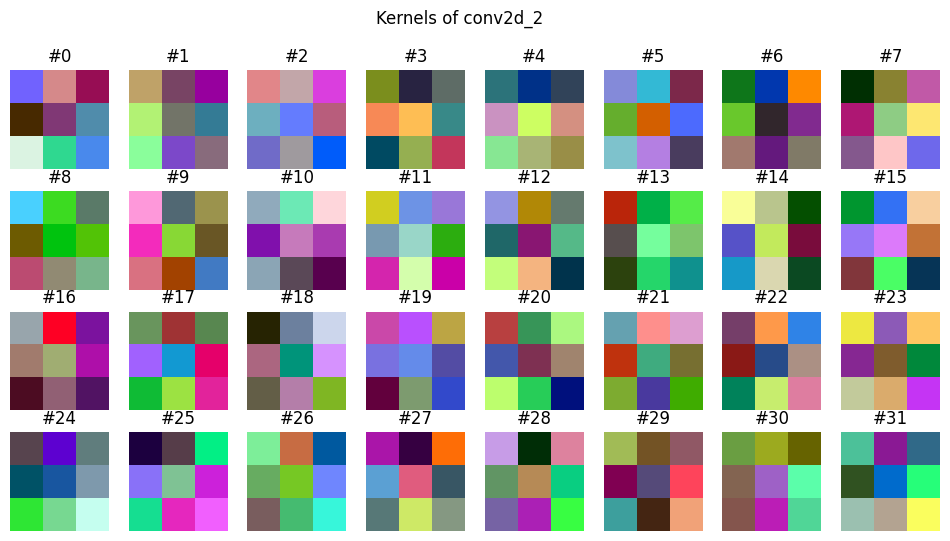

In [14]:
def visualize_conv_weights(model, layer_index=1):

    # Get weights

    # Note: Keras layer indexing might vary. Usually Input is 0.

    # We can also get by name if we named them, but let's grab the first Conv2D.

    conv_layers = [l for l in model.layers if isinstance(l, Conv2D)]

    if not conv_layers:

        print("No Conv2D layers found.")

        return

    

    target_layer = conv_layers[0]

    weights = target_layer.get_weights()[0] # [0] is weights, [1] is biases

    print(f"First Conv2D Layer Weight Shape: {weights.shape}") 

    # Shape is (KernelH, KernelW, InputChannels, Filters) e.g. (3, 3, 3, 32)

    

    n_filters = weights.shape[3]

    

    # Setup plot

    cols = 8

    rows = np.ceil(n_filters / cols).astype(int)

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows*1.5))

    

    for i, ax in enumerate(axes.flat):

        if i >= n_filters:

            break

        

        # Get the filter: (3, 3, 3)

        f = weights[:, :, :, i]

        

        # Normalize to 0-1 for display

        f_min, f_max = f.min(), f.max()

        f_disp = (f - f_min) / (f_max - f_min + 1e-5)

        

        ax.imshow(f_disp, interpolation='nearest')

        ax.axis('off')

        ax.set_title(f'#{i}')

        

    plt.suptitle(f"Kernels of {target_layer.name}")

    plt.show()



visualize_conv_weights(model_pool)


## 6. Memory Usage



**Parameter Count**:

-   Conv2D parameters = `(kernel_h * kernel_w * input_channels + 1) * filters`

-   Dense parameters = `(input_units + 1) * output_units`



**Activation Memory** (Forward Pass):

-   Layer Output Bytes = `Height * Width * Filters * 4 bytes (float32)`



## 7. Batch Normalization



We add `BatchNormalization()` after each `Conv2D` and `Dense` layer to normalize activation distributions.

This often allows higher learning rates and faster convergence.



In [ ]:
def create_cnn_bn(input_shape, dense_size, classes):

    kernel_sz = (3, 3)

    x = Input(shape=input_shape)

    

    # Block 1

    y = Conv2D(filters=32, kernel_size=kernel_sz, strides=1, activation='relu', 

               padding='same', kernel_initializer='he_normal')(x)

    y = BatchNormalization()(y)

    y = MaxPooling2D()(y)

    

    # Block 2

    y = Conv2D(filters=64, kernel_size=kernel_sz, strides=1, activation='relu', 

               padding='same', kernel_initializer='he_normal')(y)

    y = BatchNormalization()(y)

    y = MaxPooling2D()(y)

    

    y = Flatten()(y)

    y = Dense(dense_size, activation='relu')(y)

    y = BatchNormalization()(y)

    

    y = Dense(classes, activation='softmax')(y)

    

    model = Model(inputs=x, outputs=y)

    return model



print("--- Training CNN with BN ---")

model_bn = create_cnn_bn(dims, dense_sz, class_count)

model_bn.compile(loss='sparse_categorical_crossentropy', 

                 optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), 

                 metrics=['accuracy'])



history_bn = model_bn.fit(x_train, y_train, epochs=12, validation_data=(x_val, y_val), verbose=2)

score_bn = model_bn.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy (BN): {score_bn[1]:.4f}')


## 8. L2 Regularization



We apply L2 regularization to weights to prevent overfitting.



In [ ]:
def create_cnn_l2(input_shape, dense_size, classes, l2_strength=1e-4):

    kernel_sz = (3, 3)

    reg = regularizers.l2(l2_strength)

    x = Input(shape=input_shape)

    

    # Block 1

    y = Conv2D(filters=32, kernel_size=kernel_sz, strides=1, activation='relu', 

               padding='same', kernel_initializer='he_normal', kernel_regularizer=reg)(x)

    y = BatchNormalization()(y)

    y = MaxPooling2D()(y)

    

    # Block 2

    y = Conv2D(filters=64, kernel_size=kernel_sz, strides=1, activation='relu', 

               padding='same', kernel_initializer='he_normal', kernel_regularizer=reg)(y)

    y = BatchNormalization()(y)

    y = MaxPooling2D()(y)

    

    y = Flatten()(y)

    y = Dense(dense_size, activation='relu', kernel_regularizer=reg)(y)

    y = BatchNormalization()(y)

    

    y = Dense(classes, activation='softmax', kernel_regularizer=reg)(y)

    

    model = Model(inputs=x, outputs=y)

    return model



print("--- Training CNN with L2 ---")

model_l2 = create_cnn_l2(dims, dense_sz, class_count, l2_strength=0.001)

model_l2.compile(loss='sparse_categorical_crossentropy', 

                 optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), 

                 metrics=['accuracy'])



history_l2 = model_l2.fit(x_train, y_train, epochs=12, validation_data=(x_val, y_val), verbose=2)

score_l2 = model_l2.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy (L2): {score_l2[1]:.4f}')
